# Building convolutional neural networks in Tensorflow and Keras

# Convolutional neural networks
  
Text.

inputs = (n_inputs, pixel_width, pixel_height, depth) = (1797, 8, 8, 1)
labels = (n_inputs) = (1797,)


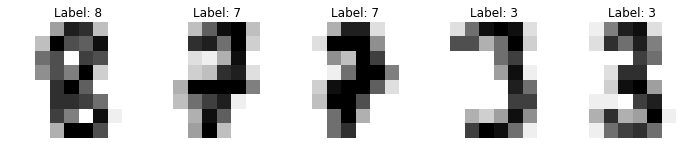

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

# RGB images have a depth of 3
# our image is grayscale so it should have a depth of 1
inputs = inputs[:,:,:,np.newaxis]

print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# choose some random images to display
n_inputs = len(inputs)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()


In [2]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# onehot representation of labels
labels = to_categorical(labels)

# split into train and test data
# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

Using TensorFlow backend.


In [3]:
import tensorflow as tf

class ConvolutionalNeuralNetworkTensorflow:
    def __init__(
        self,
        X_train,
        Y_train,
        X_test,
        Y_test,
        n_filters=10,
        n_neurons_connected=100,
        n_categories=10,
        receptive_field=3,
        stride=1,
        padding=1,
        epochs=10,
        batch_size=100,
        eta=0.1,
        lmbd=0.0,
    ):
        
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
        self.n_inputs, self.input_width, self.input_height, self.depth = X_train.shape
        
        self.n_filters = n_filters
        self.n_downsampled = int(self.input_width*self.input_height*n_filters / 4)
        self.n_neurons_connected = n_neurons_connected
        self.n_categories = n_categories
        
        self.receptive_field = receptive_field
        self.stride = stride
        self.strides = [stride, stride, stride, stride]
        self.padding = padding
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        self.create_placeholders()
        self.create_CNN()
        self.create_loss()
        self.create_optimiser()
        self.create_accuracy()
    
    def create_placeholders(self):
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, shape=(None, self.input_width, self.input_height, self.depth), name='X_data')
            self.Y = tf.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_CNN(self):
        with tf.name_scope('CNN'):
            
            # Convolutional layer
            self.W_conv = self.weight_variable([self.receptive_field, self.receptive_field, self.depth, self.n_filters], name='conv', dtype=tf.float32)
            b_conv = self.weight_variable([self.n_filters], name='conv', dtype=tf.float32)
            z_conv = tf.nn.conv2d(self.X, self.W_conv, self.strides, padding='SAME', name='conv') + b_conv
            a_conv = tf.nn.relu(z_conv)
            
            # 2x2 max pooling
            a_pool = tf.nn.max_pool(a_conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME', name='pool')
            
            # Fully connected layer
            a_pool_flat = tf.reshape(a_pool, [-1, self.n_downsampled])
            self.W_fc = self.weight_variable([self.n_downsampled, self.n_neurons_connected], name='fc', dtype=tf.float32)
            b_fc = self.bias_variable([self.n_neurons_connected], name='fc', dtype=tf.float32)
            a_fc = tf.nn.relu(tf.matmul(a_pool_flat, self.W_fc) + b_fc)
            
            # Output layer
            self.W_out = self.weight_variable([self.n_neurons_connected, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc, self.W_out) + b_out
    
    def create_loss(self):
        with tf.name_scope('loss'):
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=self.z_out))
            
            #regularizer_loss_fc1 = tf.nn.l2_loss(self.W_fc1)
            #regularizer_loss_fc2 = tf.nn.l2_loss(self.W_fc2)
            #regularizer_loss_out = tf.nn.l2_loss(self.W_out)
            #regularizer_loss = self.lmbd*(regularizer_loss_fc1 + regularizer_loss_fc2 + regularizer_loss_out)
            
            self.loss = softmax_loss #+ regularizer_loss

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            probabilities = tf.nn.softmax(self.z_out)
            predictions = tf.argmax(probabilities, 1)
            labels = tf.argmax(self.Y, 1)
            
            correct_predictions = tf.equal(predictions, labels)
            correct_predictions = tf.cast(correct_predictions, tf.float32)
            self.accuracy = tf.reduce_mean(correct_predictions)
    
    def create_optimiser(self):
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)

    def fit(self):
        data_indices = np.arange(self.n_inputs)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epochs):
                for j in range(self.iterations):
                    chosen_datapoints = np.random.choice(data_indices, size=self.batch_size, replace=False)
                    batch_X, batch_Y = self.X_train[chosen_datapoints], self.Y_train[chosen_datapoints]
            
                    sess.run([CNN.loss, CNN.optimizer],
                        feed_dict={CNN.X: batch_X,
                                   CNN.Y: batch_Y})
                    accuracy = sess.run(CNN.accuracy,
                        feed_dict={CNN.X: batch_X,
                                   CNN.Y: batch_Y})
                    step = sess.run(CNN.global_step)
    
            self.train_loss, self.train_accuracy = sess.run([CNN.loss, CNN.accuracy],
                feed_dict={CNN.X: self.X_train,
                           CNN.Y: self.Y_train})
        
            self.test_loss, self.test_accuracy = sess.run([CNN.loss, CNN.accuracy],
                feed_dict={CNN.X: self.X_test,
                           CNN.Y: self.Y_test})

In [4]:
from sklearn.metrics import accuracy_score

epochs = 100
batch_size = 100
n_filters=10
n_neurons_connected=50
n_categories=10

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)


In [5]:
CNN_tf = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = ConvolutionalNeuralNetworkTensorflow(X_train, Y_train, X_test, Y_test,
                                      n_filters=n_filters, n_neurons_connected=n_neurons_connected,
                                      n_categories=n_categories, epochs=epochs, batch_size=batch_size,
                                      eta=eta, lmbd=lmbd)
        CNN.fit()
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % CNN.test_accuracy)
        print()
            
        CNN_tf[i][j] = CNN

Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.036

Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.183

Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.086

Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.139

Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.083

Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.067

Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.125

Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.292

Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 0.436

Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 0.131

Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 0.319

Learning rate =  0.0001
Lambda =  0.1
Test accuracy: 0.267

Learning rate =  0.0001
Lambda =  1.0
Test accuracy: 0.456

Learning rate =  0.0001
Lambda =  10.0
Test accuracy: 0.283

Learning rate =  0.001
Lambda =  1e-05
Test accuracy: 0.911

Learning rate =  0.001
Lambda =  0.0001
Test accuracy: 0.919

Learning rate =  0.001
Lam

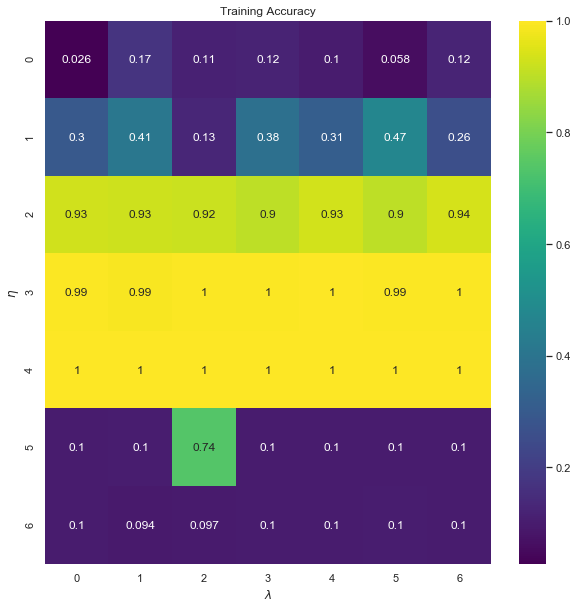

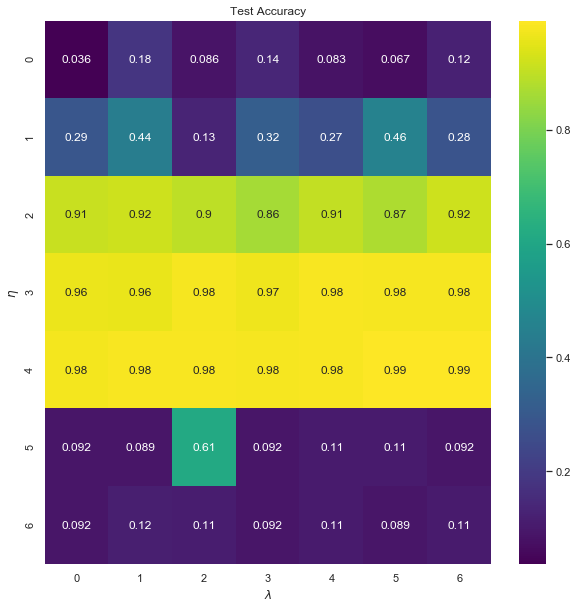

In [6]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_tf[i][j]

        train_accuracy[i][j] = CNN.train_accuracy
        test_accuracy[i][j] = CNN.test_accuracy

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()


In [7]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

def create_CNN(input_shape, n_filters, receptive_field, n_neurons_connected, n_categories):
    model = Sequential()
    model.add(Conv2D(n_filters, (receptive_field, receptive_field), input_shape=input_shape, padding='same',
              activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(n_neurons_connected, activation='relu'))
    model.add(Dense(n_categories, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    return model

input_shape = X_train.shape[1:4]
model = create_CNN(input_shape, n_filters, 3, n_neurons_connected, n_categories)
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

scores = model.evaluate(X_test, Y_test)
print("Accuracy: %.3f" % scores[1])

TypeError: softmax() got an unexpected keyword argument 'axis'